In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [2]:
def projectile_motion_with_resistance(state, t, g, k, m):
    x, y, v_x, v_y = state
    n = 3
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = -(k/m) * v_x**n 
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dx_dt, dy_dt, dv_x_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.1  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件
x0 = 0.0  # 初始水平位置
y0 = 10  # 初始垂直位置
v_x0 = 2.0  # 初始水平速度
v_y0 = 0  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 100)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [x0, y0, v_x0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k, m))

# 提取位置和速度信息
x_with_resistance = solution_with_resistance[:, 0]
y_with_resistance = solution_with_resistance[:, 1]
v_x_with_resistance = solution_with_resistance[:, 2]
v_y_with_resistance = solution_with_resistance[:, 3]

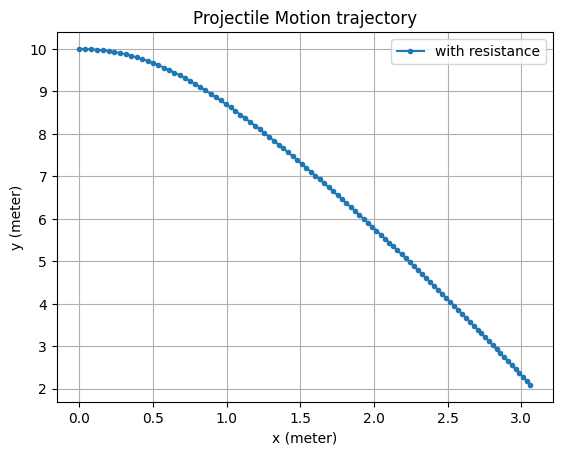

In [3]:
# 绘制轨迹
plt.plot(x_with_resistance, y_with_resistance, label = 'with resistance', marker='o', markersize = 3)
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
n_train = 20
t_train = ts[:n_train]
x_train = x_with_resistance[:n_train]
y_train = y_with_resistance[:n_train]

In [24]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

reg_ylabel = torch.from_numpy(y_train).type(torch.float32)
reg_ylabel = reg_ylabel[:,None]


f_y = np.random.uniform(0, 5, n_f)
f_yt = np.random.uniform(0, 5, n_f)

f_data_y = np.vstack([f_y, f_yt]).T

f_y = Variable(torch.from_numpy(f_data_y[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_yt = Variable(torch.from_numpy(f_data_y[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset_y = torch.utils.data.TensorDataset(f_y, f_yt)

f_data_loader_y = torch.utils.data.DataLoader(f_dataset_y, batch_size = f_batch_size, shuffle=True)

In [17]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model_y = MLP()

def f_y(t, k, m, n, g):
    u = model_y(t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    return u_tt + (k/m)*u_t**n + g

optimizer_y = optim.Adam(model_y.parameters(), lr=1e-3)

In [18]:
# Training the PINN in y direction
n_epoch = 20
for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_y):

        optimizer_y.zero_grad()
        pred = model_y(reg_in)
        reg_loss = torch.mean((reg_ylabel - pred) ** 2)
        f_loss = torch.mean(f_y(t, k, m, 3, g) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_y.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

100%|██████████| 313/313 [00:01<00:00, 275.30it/s]


epoch = 0, loss = 0.023908060044050217
epoch = 0, f_loss = 0.016204768791794777
epoch = 0, reg_loss = 0.0077032907865941525


100%|██████████| 313/313 [00:01<00:00, 280.24it/s]


epoch = 1, loss = 0.004932254087179899
epoch = 1, f_loss = 0.004794212989509106
epoch = 1, reg_loss = 0.0001380411849822849


100%|██████████| 313/313 [00:01<00:00, 272.04it/s]


epoch = 2, loss = 0.008079497143626213
epoch = 2, f_loss = 0.008025608025491238
epoch = 2, reg_loss = 5.388922363636084e-05


100%|██████████| 313/313 [00:01<00:00, 281.94it/s]


epoch = 3, loss = 0.0017200721194967628
epoch = 3, f_loss = 0.0008470176253467798
epoch = 3, reg_loss = 0.0008730544941499829


100%|██████████| 313/313 [00:01<00:00, 278.71it/s]


epoch = 4, loss = 0.0007118735229596496
epoch = 4, f_loss = 0.0007104725809767842
epoch = 4, reg_loss = 1.4009300457473728e-06


100%|██████████| 313/313 [00:01<00:00, 278.70it/s]


epoch = 5, loss = 0.00034219553344883025
epoch = 5, f_loss = 0.00033778202487155795
epoch = 5, reg_loss = 4.413499937072629e-06


100%|██████████| 313/313 [00:01<00:00, 278.38it/s]


epoch = 6, loss = 0.00028681886033155024
epoch = 6, f_loss = 0.0002821082598529756
epoch = 6, reg_loss = 4.7106009333219845e-06


100%|██████████| 313/313 [00:01<00:00, 270.77it/s]


epoch = 7, loss = 0.00042411318281665444
epoch = 7, f_loss = 0.0004074694006703794
epoch = 7, reg_loss = 1.6643778508296236e-05


100%|██████████| 313/313 [00:01<00:00, 275.68it/s]


epoch = 8, loss = 0.01863669417798519
epoch = 8, f_loss = 0.018556680530309677
epoch = 8, reg_loss = 8.00143025116995e-05


100%|██████████| 313/313 [00:01<00:00, 278.19it/s]


epoch = 9, loss = 0.00012804513971786946
epoch = 9, f_loss = 0.00012591853737831116
epoch = 9, reg_loss = 2.1266080239001894e-06


100%|██████████| 313/313 [00:01<00:00, 261.32it/s]


epoch = 10, loss = 9.911385859595612e-05
epoch = 10, f_loss = 9.894346294458956e-05
epoch = 10, reg_loss = 1.7039751298852934e-07


100%|██████████| 313/313 [00:01<00:00, 267.86it/s]


epoch = 11, loss = 0.5124719142913818
epoch = 11, f_loss = 0.5117471218109131
epoch = 11, reg_loss = 0.000724806624930352


100%|██████████| 313/313 [00:01<00:00, 273.69it/s]


epoch = 12, loss = 0.0007882772479206324
epoch = 12, f_loss = 0.0007851546397432685
epoch = 12, reg_loss = 3.122623866147478e-06


100%|██████████| 313/313 [00:01<00:00, 233.20it/s]


epoch = 13, loss = 0.0004219783586449921
epoch = 13, f_loss = 0.00042108213528990746
epoch = 13, reg_loss = 8.962250603872235e-07


100%|██████████| 313/313 [00:01<00:00, 229.96it/s]


epoch = 14, loss = 0.002786822384223342
epoch = 14, f_loss = 0.002700583543628454
epoch = 14, reg_loss = 8.623888425063342e-05


100%|██████████| 313/313 [00:01<00:00, 203.32it/s]


epoch = 15, loss = 0.00044028437696397305
epoch = 15, f_loss = 0.00043988230754621327
epoch = 15, reg_loss = 4.0205935647463775e-07


100%|██████████| 313/313 [00:01<00:00, 229.59it/s]


epoch = 16, loss = 0.005591932684183121
epoch = 16, f_loss = 0.00555823091417551
epoch = 16, reg_loss = 3.370194463059306e-05


100%|██████████| 313/313 [00:01<00:00, 233.38it/s]


epoch = 17, loss = 0.0019753228407353163
epoch = 17, f_loss = 0.001959562534466386
epoch = 17, reg_loss = 1.576037539052777e-05


100%|██████████| 313/313 [00:01<00:00, 255.14it/s]


epoch = 18, loss = 0.0038802993949502707
epoch = 18, f_loss = 0.0038771177642047405
epoch = 18, reg_loss = 3.1816548471397255e-06


100%|██████████| 313/313 [00:01<00:00, 255.70it/s]

epoch = 19, loss = 0.000710519147105515
epoch = 19, f_loss = 0.0007101149531081319
epoch = 19, reg_loss = 4.0419612901132496e-07


In [44]:
# Train a pure MLP in y direction
model_mlp_y = MLP()
optimizer_mlp_y = optim.Adam(model_mlp_y.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp_y.zero_grad()
        pred = model_mlp_y(reg_in)
        mlp_loss = torch.mean((reg_ylabel - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp_y.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))



epoch = 0, loss = 94.92781066894531
epoch = 1, loss = 87.9054946899414
epoch = 2, loss = 81.00926971435547
epoch = 3, loss = 74.13874816894531
epoch = 4, loss = 67.2900390625
epoch = 5, loss = 60.50441360473633
epoch = 6, loss = 53.87871170043945
epoch = 7, loss = 47.538604736328125
epoch = 8, loss = 41.60613250732422
epoch = 9, loss = 36.17731475830078
epoch = 10, loss = 31.310222625732422
epoch = 11, loss = 27.023101806640625
epoch = 12, loss = 23.29986572265625
epoch = 13, loss = 20.099313735961914
epoch = 14, loss = 17.3652400970459
epoch = 15, loss = 15.035512924194336
epoch = 16, loss = 13.048940658569336
epoch = 17, loss = 11.349584579467773
epoch = 18, loss = 9.888833045959473
epoch = 19, loss = 8.625935554504395
epoch = 20, loss = 7.527560234069824
epoch = 21, loss = 6.566864013671875
epoch = 22, loss = 5.722430229187012
epoch = 23, loss = 4.977235317230225
epoch = 24, loss = 4.3177361488342285
epoch = 25, loss = 3.733081817626953
epoch = 26, loss = 3.2144973278045654
epoch = 

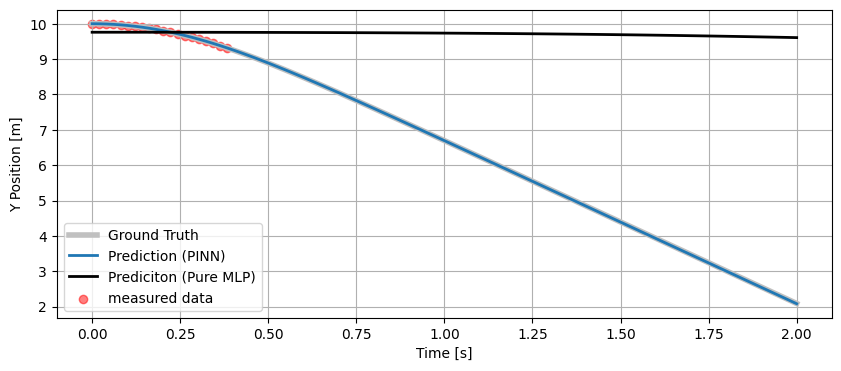

In [46]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, y_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model_y( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp_y( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, y_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Y Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)